<a href="https://colab.research.google.com/github/SvetlanaKrunic/AnalizaMedicinskeSlike/blob/main/notebooks/ViT_TF_tunner_W%26B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

The implementation is given by: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [ ]:
!pip install tensorflow-addons
!pip install tensorflow==2.10
!pip install keras-tuner

  Using cached tensorflow-2.10.0-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl.metadata (1.3 kB)
Using cached tensorflow-2.10.0-cp310-cp310-win_amd64.whl (455.9 MB)
Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Unins

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [ ]:
import tensorflow_addons as tfa
print(tfa.__version__)

0.20.0


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pickle
import keras_tuner

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Prepare the data

In [ ]:
dataset_dir = r"C:\Users\User\OneDrive - Univerzitet u Novom Sadu\Desktop\HyperKvasir\hyper-kvasir-final"

In [ ]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  23


,categorie,numbre of files
0,barretts,41
1,barretts-short-segment,53
2,bbps-0-1,646
3,bbps-2-3,1148
4,cecum,1009
5,dyed-lifted-polyps,1002
6,dyed-resection-margins,989
7,esophagitis-a,403
8,esophagitis-b-d,260
9,hemorrhoids,6


## Obtaining the entire data and labels

In [ ]:
def get_x_y(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                print(e)

    y = np.array(y)
    X = np.array(X)

    # reshape X into img_wid x img_high x 3
    X = X.reshape(X.shape[0], img_wid, img_high, 3)

    return X, y


img_wid, img_high = 224, 224
X, y = get_x_y(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (10662, 224, 224, 3)
y: (10662,)


## Visualize the data

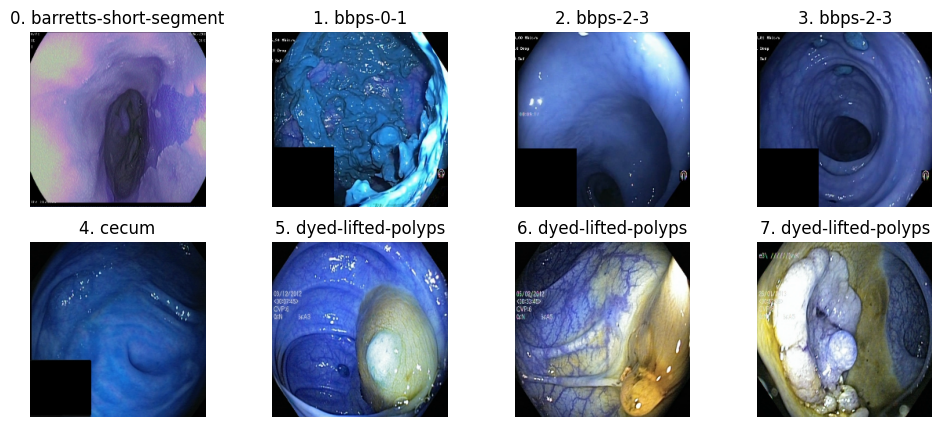

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

## Split the data into train and test

In [ ]:
Y = np.reshape(y, (len(y), 1))


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8529, 224, 224, 3)
y_train: (8529, 1)
X_test: (2133, 224, 224, 3)
y_test: (2133, 1)


# Data augmentation

In [ ]:
# Data augmentation

image_size = 224

data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

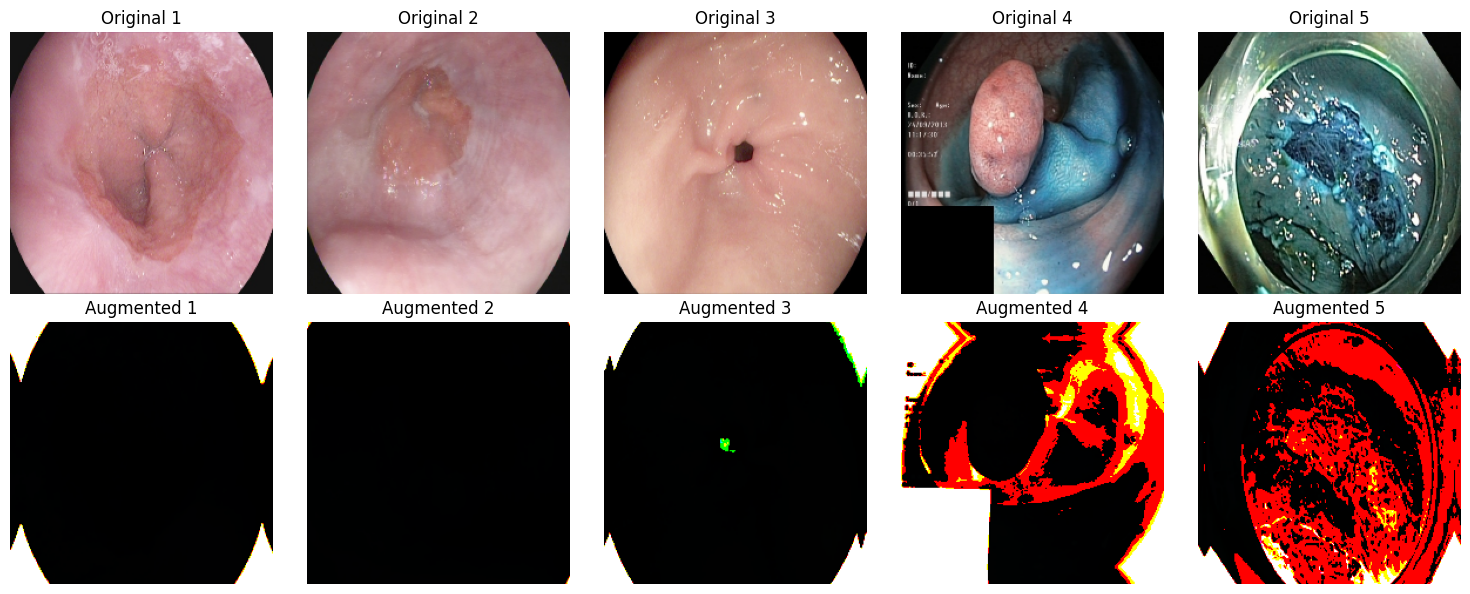

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Pretpostavimo da već imamo učitane slike u X_train
# Izaberimo nekoliko slika iz X_train za prikazivanje efekta augmentacije
sample_images = X_train[:5]  # Uzimamo prvih 5 slika

# Kreirajmo figuru za prikaz
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Prikazivanje originalnih slika
for i in range(5):
    axes[0, i].imshow(sample_images[i].astype('uint8'))
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {i+1}')

# Prikazivanje slika nakon augmentacije
augmented_images = data_augmentation(sample_images)

for i in range(5):
    axes[1, i].imshow(augmented_images[i].numpy().astype('uint8'))
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()


# Building the ViT model


## Multi-Layer-Perceptron (MLP)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation layer

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Hyper-parameters

In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 2 #povecavaj kad budes stvarno trenirala, ovo je proba sa 2 epohe
image_size = 224  # We'll resize input images to this size
patch_size = 24  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
seed = 1

(-0.5, 223.5, 223.5, -0.5)

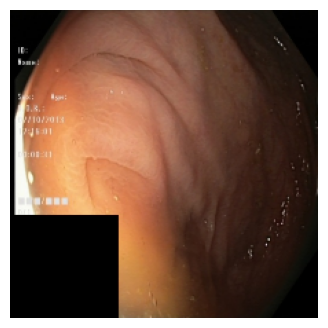

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 224 X 224
Patch size: 24 X 24
Patches per image: 81
Elements per patch: 1728


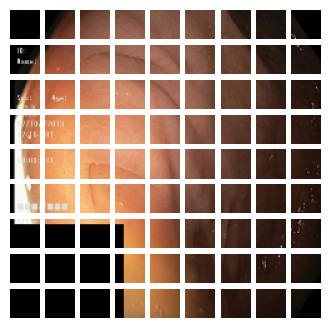

In [ ]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding layer

In [ ]:
# Define a custom layer class that inherits from Keras' Layer class.

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim): #Constructor method to initialize the layer
        super(PatchEncoder, self).__init__() #Call the parent class constructor to initialize the layer

        #Define the number of patches and projection dimension as attributes
        self.num_patches = num_patches

        #Dense layer for projecting the input patches into a higher-dimensional space
        self.projection = layers.Dense(units=projection_dim)

        #Embedding layer to store positional encodings for each patch
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch): #Define the forward pass for this layer
        positions = tf.range(start=0, limit=self.num_patches, delta=1) #Create a tensor with patch indices (positions)
        #Project the patches using the dense layer, and add positional encodings to them
        encoded = self.projection(patch) + self.position_embedding(positions)

        return encoded  #Return the final encoded representation of the patches with added position information


# Final ViT model

In [ ]:
num_classes = 23
input_shape = (224, 224, 3)

def optimize_vit_classifier(hp):

    # Five steps approach to select a initial seed
    tf.random.set_seed(hp.Choice('seed', [1, 2]))

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patch_size = hp.Choice('patch_size', [12, 18, 24])
    num_patches = (image_size // patch_size) ** 2
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    projection_dim = hp.Choice('projection_dim', [16, 32, 64, 128])
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    transformer_units = [
      projection_dim * 2,
      projection_dim,
    ]

    # Create multiple layers of the Transformer block.
    for _ in range(hp.Choice('transformer_layers', [4, 8, 12, 16])):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compiling the final  model
    optimizer = AdamW(
        learning_rate=hp.Choice('learning_rate', [0.00001, 0.0001, 0.001, 0.01]), weight_decay=hp.Choice('weight_decay', [0.00001, 0.0001, 0.001, 0.01])
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ],
    )

    return model


# Pre-tunning

In [ ]:
from keras_tuner import RandomSearch

# tuner for function
tuner = RandomSearch(
    optimize_vit_classifier,
    objective='val_accuracy',
    max_trials=10000,
    overwrite=True,
    executions_per_trial=1)

NASILNO PREKINULA JER MOZE DA IDE DO 1000 - PREDUGO TRAJE!

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best weight_decay: {best_hps.get('weight_decay')}")
print(f"Best projection_dim: {best_hps.get('projection_dim')}")
print(f"Best transfomers units: [{int(best_hps.get('projection_dim')) * 2}, {best_hps.get('projection_dim')}]")
print(f"transformer_layers: {best_hps.get('transformer_layers')}")
print(f"Best patch_size: {best_hps.get('patch_size')}")
print(f"Best number of patches: {(image_size // int(best_hps.get('patch_size'))) ** 2}")
print(f"Best seed: {best_hps.get('seed')}")

Trial 35 Complete [00h 11m 31s]
val_accuracy: 0.19971869885921478

Best val_accuracy So Far: 0.7632442712783813
Total elapsed time: 1d 01h 34m 24s

Search: Running Trial #36

Value             |Best Value So Far |Hyperparameter
2                 |1                 |seed
12                |12                |patch_size
128               |128               |projection_dim
8                 |4                 |transformer_layers
0.0001            |0.0001            |learning_rate
0.001             |0.0001            |weight_decay

Epoch 1/5
267/267 [==============================] - 1805s 7s/step - loss: 2.1326 - accuracy: 0.4706 - top-5-accuracy: 0.8575 - val_loss: 1.4483 - val_accuracy: 0.5016 - val_top-5-accuracy: 0.9081
Epoch 2/5
 70/267 [======>.......................] - ETA: 20:35 - loss: 1.2117 - accuracy: 0.6013 - top-5-accuracy: 0.9393

KeyboardInterrupt: 

In [ ]:
from keras_tuner import RandomSearch

# tuner for function
tuner = RandomSearch(
    optimize_vit_classifier,
    objective='val_accuracy',
    max_trials=3,
    overwrite=True,
    executions_per_trial=1)

tuner.search(X_train, y_train, epochs=2, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best weight_decay: {best_hps.get('weight_decay')}")
print(f"Best projection_dim: {best_hps.get('projection_dim')}")
print(f"Best transfomers units: [{int(best_hps.get('projection_dim')) * 2}, {best_hps.get('projection_dim')}]")
print(f"transformer_layers: {best_hps.get('transformer_layers')}")
print(f"Best patch_size: {best_hps.get('patch_size')}")
print(f"Best number of patches: {(image_size // int(best_hps.get('patch_size'))) ** 2}")
print(f"Best seed: {best_hps.get('seed')}")

Trial 2 Complete [00h 06m 17s]
val_accuracy: 0.10501641035079956

Best val_accuracy So Far: 0.5185185074806213
Total elapsed time: 00h 15m 14s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
2                 |1                 |seed
12                |18                |patch_size
128               |16                |projection_dim
12                |12                |transformer_layers
0.001             |0.0001            |learning_rate
1e-05             |0.0001            |weight_decay

Epoch 1/2
267/267 [==============================] - 3297s 12s/step - loss: 4.1547 - accuracy: 0.3235 - top-5-accuracy: 0.7523 - val_loss: 1.5795 - val_accuracy: 0.4937 - val_top-5-accuracy: 0.9067
Epoch 2/2
137/267 [==============>...............] - ETA: 24:13 - loss: 1.8305 - accuracy: 0.4359 - top-5-accuracy: 0.8656

# Using W&D Tunning

In [ ]:
#!pip uninstall wandb
!pip install wandb==0.12.0

  Using cached wandb-0.12.0-py2.py3-none-any.whl.metadata (7.1 kB)
Using cached wandb-0.12.0-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: wandb
    Found existing installation: wandb 0.19.8
    Uninstalling wandb-0.19.8:
      Successfully uninstalled wandb-0.19.8


In [ ]:
!pip install --upgrade wandb

  Using cached wandb-0.19.8-py3-none-win_amd64.whl.metadata (10 kB)
Using cached wandb-0.19.8-py3-none-win_amd64.whl (20.2 MB)
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.0
    Uninstalling wandb-0.12.0:
      Successfully uninstalled wandb-0.12.0


In [ ]:
import wandb
print(wandb.__version__)


0.19.8


In [ ]:
!wandb login

wandb: Currently logged in as: skrunic43 (skrunic43-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
!pip show wandb

Name: wandb
Version: 0.19.8
Summary: A CLI and library for interacting with the Weights & Biases API.
Home-page: 
Author: 
Author-email: Weights & Biases <support@wandb.com>
License: MIT License
        
        Copyright (c) 2021 Weights and Biases, Inc.
        
        Permission is hereby granted, free of charge, to any person obtaining a copy
        of this software and associated documentation files (the "Software"), to deal
        in the Software without restriction, including without limitation the rights
        to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
        copies of the Software, and to permit persons to whom the Software is
        furnished to do so, subject to the following conditions:
        
        The above copyright notice and this permission notice shall be included in all
        copies or substantial portions of the Software.
        
        THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
        IM

In [ ]:
!pip install --upgrade wandb

In [ ]:
import wandb
#from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
#from wandb.keras import WandbCallback  # Za logovanje metrika tokom treniranja
import os
#prepravi!
os.environ['WANDB_NOTEBOOK_NAME'] = r'C:\Users\User\OneDrive - Univerzitet u Novom Sadu\Documents\GitHub\AnalizaMedicinskeSlike\...'

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find C:\Users\User\OneDrive - Univerzitet u Novom Sadu\Documents\GitHub\AnalizaMedicinskeSlike\3.1-prvi-vit-tf-sa-tunner.ipynb.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: skrunic43 (skrunic43-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
num_classes = 23
input_shape = (224, 224, 3)

def get_vit_classifier(seed: int, patch_size: int, projection_dim: int, transformers_layer: int,
                            learning_rate: float, weight_decay: float):

    # Five steps approach to select a initial seed
    tf.random.set_seed(seed)

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    num_patches = (image_size // patch_size) ** 2
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    transformer_units = [
      projection_dim * 2,
      projection_dim,
    ]

    # Create multiple layers of the Transformer block.
    for _ in range(transformers_layer):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compiling the final  model
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ],
    )

    return model


In [ ]:
sweep_config = {
    'method': 'bayes'
}


metric = {
    'name': 'val_loss',
    'goal': 'minimize'
}

sweep_config['metric'] = metric

parameters_dict = {
    'seed': {
        'values': [1, 2, 3, 4, 5]
        },
    'patch_size': {
          'values': [12, 16, 20, 24]
        },
    'projection_dim': {
          'values': [16, 32, 64, 128]
        },
    'transfomers_layers': {
          'values': [4, 8, 12, 16]
        },
    'learning_rate': {
        'values': [0.00001, 0.0001, 0.001, 0.01]
    },
    'weight_decay': {
        'values': [0.00001, 0.0001, 0.001, 0.01]
    },
    'batch_size': {
        'values': [32, 64, 128, 256]
    }
}

sweep_config['parameters'] = parameters_dict


parameters_dict.update({
    'epochs': {
        'value': 5
    }
})

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'val_loss'},
 'parameters': {'batch_size': {'values': [32, 64, 128, 256]},
                'epochs': {'value': 5},
                'learning_rate': {'values': [1e-05, 0.0001, 0.001, 0.01]},
                'patch_size': {'values': [12, 16, 20, 24]},
                'projection_dim': {'values': [16, 32, 64, 128]},
                'seed': {'values': [1, 2, 3, 4, 5]},
                'transfomers_layers': {'values': [4, 8, 12, 16]},
                'weight_decay': {'values': [1e-05, 0.0001, 0.001, 0.01]}}}


In [ ]:
def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "vit-prvi-pokusaj"
        wandb.config.dataset_name = "Hyper-Kvasir"

        #wandb.init(entity="user_name")

        # initialize model
        model = get_vit_classifier(wandb.config.seed, wandb.config.patch_size, wandb.config.projection_dim,
                                   wandb.config.transfomers_layers, wandb.config.learning_rate, wandb.config.weight_decay)

        # callback setup
        wandb_callbacks = [
            WandbMetricsLogger() # We can add a checkpoint
        ]

        model.fit(X_train,
                  y_train,
                  batch_size=wandb.config.batch_size,
                  epochs=wandb.config.epochs,
                  validation_split=0.2,
                  callbacks=wandb_callbacks)

#PROBLEM!

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="AMS2024", entity="skrunic43")

403 response executing GraphQL.
{"errors":[{"message":"permission denied","path":["upsertSweep"],"extensions":{"code":"PERMISSION_ERROR"}}],"data":{"upsertSweep":null}}
wandb: ERROR Error while calling W&B API: permission denied (<Response [403]>)


UsageError: permission denied

In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10000)

NameError: name 'sweep_id' is not defined

# Run the experiment

In [ ]:
model = create_vit_classifier()
model.summary()

NameError: name 'create_vit_classifier' is not defined

In [ ]:
!pip install wandb
!wandb login

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="AMS2024", entity="skrunic43")

ModuleNotFoundError: No module named 'wandb.keras'

In [ ]:
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "weight_decay": weight_decay,
  "image_size": image_size,
  "patch_size": patch_size,
  "num_patches": num_patches,
  "projection_dim": projection_dim,
  "num_heads": num_heads,
  "transformer_units_x": projection_dim * 2,
  "transformer_units_y": projection_dim,
  "transformer_layers": transformer_layers,
  "mlp_head_units_x": mlp_head_units[0],
  "mlp_head_units_y": mlp_head_units[1],
  "random_seed": seed
}

NameError: name 'learning_rate' is not defined

In [ ]:
def run_experiment(model):
    checkpoint_model_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".h5"
    checkpoint_filepath = f"C:\Users\User\OneDrive - Univerzitet u Novom Sadu\Documents\GitHub\AnalizaMedicinskeSlike\treninzi\{checkpoint_model_name}"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    wandb.run.finish()

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

history_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".log"

with open(f'C:\Users\User\OneDrive - Univerzitet u Novom Sadu\Documents\GitHub\AnalizaMedicinskeSlike\treninzi\logs\{history_name}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (785610464.py, line 3)

In [ ]:
wandb.run.finish()

In [ ]:
with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', "rb") as file_pi:
    history = pickle.load(file_pi)

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history_name' is not defined

In [ ]:
import wandb

run = wandb.init()
artifact = run.use_artifact('...', type='model')
artifact_dir = artifact.download()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: skrunic43 (skrunic43-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


CommError: HTTP 400: artifacts must be specified as 'collection:alias'

In [ ]:
#model = keras.models.load_model('artifacts/...')

In [ ]:
#model.evaluate(X_test, y_test)